Text(0.5, 1.0, 'noisy im')

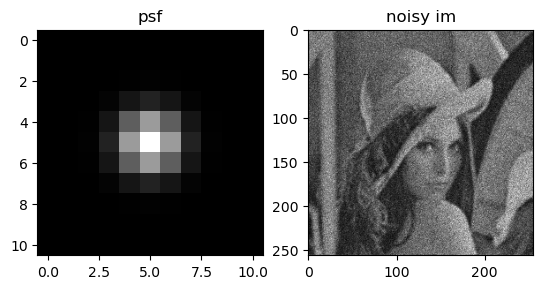

In [9]:
import site
site.addsitedir('C:\\Users\\hyan\\OneDrive - Brookhaven National Laboratory\\Jupyter')

from skimage.metrics import structural_similarity as ssim

from deconv import *

# load test image and add noise


im = tf.imread('lena256.tif')
im = im/np.max(im)

# create a point spread function with Gaussian shape
psf_row = 11
psf_col = 11
psf_w = 1
psf = gauss([psf_row,psf_col],psf_w)


sz = np.shape(im)
# conv_med only matters when scale is larger than 1
# 'dilation' for step scan and 'average' for flyscan
conv_med = ['dilation','dilation']
# upscaling factor: if the original image size is [w,w] and after convolution it is [w/2,w/2]
# then scale = [2,2]
scale = [1,1]

# create a sparse convolution matrix including downscaling 
H = sp_conv_mat_v1(scale,(int(sz[0]/scale[0]),int(sz[1]/scale[1])),psf,conv_med = conv_med)

# White noise
''' 
# convolution is described as y = H@x + e
im_conv = np.reshape(H@im.ravel(),(int(sz[0]/scale[0]),int(sz[1]/scale[1])))
row,col = im_conv.shape
noise = np.random.randn(row,col)*0.05
plt.subplot(121)
plt.imshow(psf,cmap='gray')
plt.title('psf')
plt.subplot(122)
plt.imshow(im_conv+noise,cmap = 'gray')
plt.title('conv+noise')
'''

# Poisson noise
max_int = 50
im_s = im/np.max(im)*max_int
im_conv = np.reshape(H@im_s.ravel(),(int(sz[0]/scale[0]),int(sz[1]/scale[1])))
im_noise = np.random.poisson(im_conv)
plt.subplot(121)
plt.imshow(psf,cmap='gray')
plt.title('psf')
plt.subplot(122)
plt.imshow(im_noise,cmap = 'gray')
plt.title('noisy im')


2

In [5]:
# for white noise and intensity scaled to 0 - 1
# note: ADMM_TV is a very fast FFT-based deconv/denoise algorithm, but only works with scale =[1,1]
# also, for algorithms with Total Variation (TV), a large mu mean less TV regularization
# On the contrary,it is a stronger regularization for BM3D  

st = time.process_time()
im_deconv_ADMM_TV,loss_ADMM_TV,rdiff_ADMM_TV = deconv(im_conv+noise,psf,scale,80,conv_med = conv_med, deconv_med='ADMM_TV', max_iter = 25)
et = time.process_time()
t_ADMM_TV = et - st

st = time.process_time()
im_deconv_APG_BM3D,loss_APG_BM3D,rdiff_APG_BM3D = deconv(im_conv+noise,psf,scale,0.035,conv_med = conv_med, deconv_med='APG_BM3D', max_iter = 25)
et = time.process_time()
t_APG_BM3D = et - st

st = time.process_time()
im_deconv_APG_TV,loss_APG_TV,rdiff_APG_TV = deconv(im_conv+noise,psf,scale,80,conv_med = conv_med, deconv_med='APG_TV',max_iter = 25)
et = time.process_time()
t_APG_TV = et - st

psnr_ADMM_TV = PSNR(im,im_deconv_ADMM_TV)
psnr_APG_TV = PSNR(im,im_deconv_APG_TV)
psnr_APG_BM3D = PSNR(im,im_deconv_APG_BM3D)

rmse_ADMM_TV = RMSE(im,im_deconv_ADMM_TV)
rmse_APG_TV = RMSE(im,im_deconv_APG_TV)
rmse_APG_BM3D = RMSE(im,im_deconv_APG_BM3D)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(im,cmap='gray')
plt.title('original')
plt.subplot(232)
plt.imshow(im_conv+noise,cmap='gray',vmin=0,vmax=1)
plt.title('conv+noise')
plt.subplot(233)
plt.imshow(im_deconv_ADMM_TV,cmap='gray',vmin=0,vmax=1)
plt.title('ADMM_TV')
plt.subplot(234)
plt.imshow(im_deconv_APG_TV,cmap='gray',vmin=0,vmax=1)
plt.title('APG_TV')
plt.subplot(235)
plt.imshow(im_deconv_APG_BM3D,cmap='gray',vmin=0,vmax=1)
plt.title('APG_BM3D')

plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(loss_APG_BM3D)
plt.title('APG_BM3D loss')
plt.subplot(122)
plt.plot(rdiff_APG_BM3D)
plt.title('APG_BM3D rdiff')

print('\tADMM_TV\tAPG_TV\tAPG_BM3D\n')
print('PSNR:\t%4.3f\t%4.3f\t%4.3f\n'%(psnr_ADMM_TV,psnr_APG_TV,psnr_APG_BM3D))
print('RMSE:\t%4.3f\t%4.3f\t%4.3f\n'%(rmse_ADMM_TV,rmse_APG_TV,rmse_APG_BM3D))
print('TIME:\t%4.3f\t%4.3f\t%4.3f\n'%(t_ADMM_TV,t_APG_TV,t_APG_BM3D))

KeyboardInterrupt: 

	ADMM_TV	APG_TV	APG_BM3D

PSNR:	16.752	16.747	16.825

RMSE:	37.064	37.083	36.755

SSIM:	0.806	0.804	0.830

TIME:	0.375	17.859	68.234



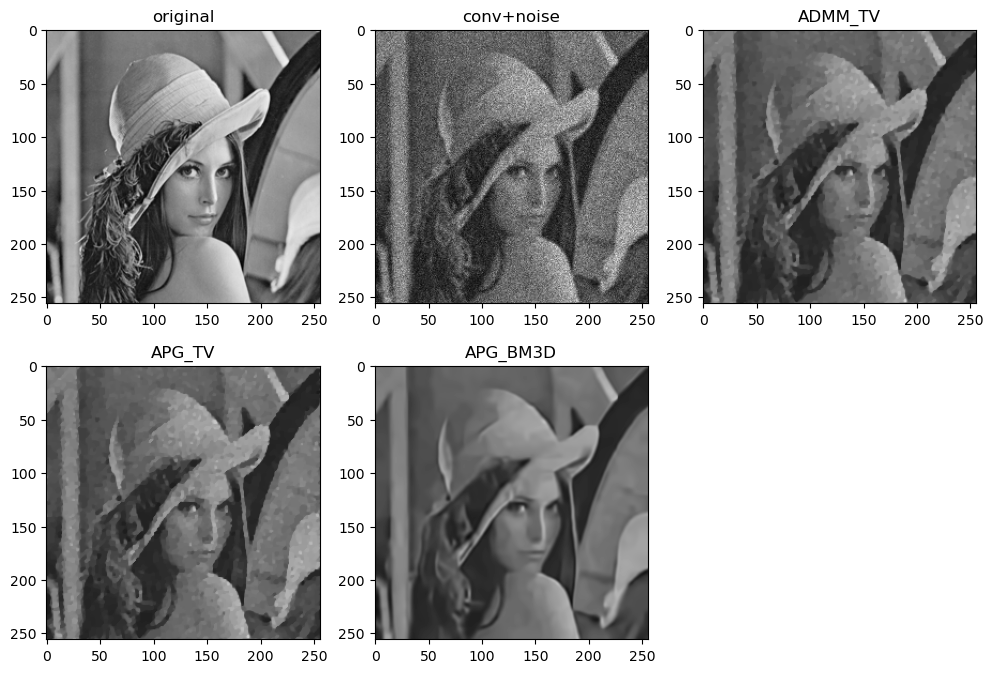

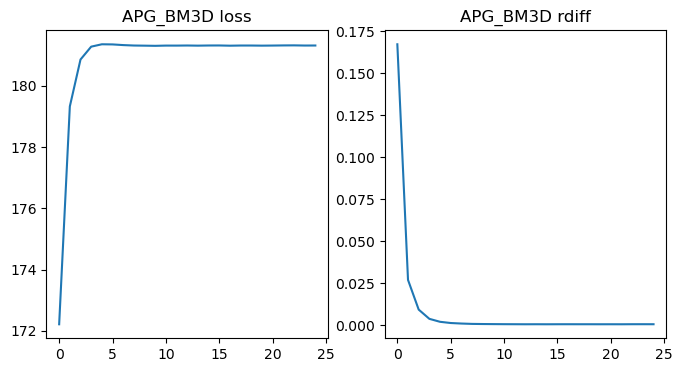

In [17]:
# for Poisson noise
# note: ADMM_TV is a very fast FFT-based deconv/denoise algorithm, but only works with scale =[1,1]
# also, for algorithms with Total Variation (TV), a large mu mean less TV regularization
# On the contrary,it is a stronger regularization for BM3D  

# intensity scaling factor
f = np.max(im_noise)

st = time.process_time()
im_deconv_ADMM_TV,loss_ADMM_TV,rdiff_ADMM_TV = deconv(im_noise/f,psf,scale,50,conv_med = conv_med, deconv_med='ADMM_TV', max_iter = 25)
et = time.process_time()
t_ADMM_TV = et - st

st = time.process_time()
im_deconv_APG_BM3D,loss_APG_BM3D,rdiff_APG_BM3D = deconv(im_noise/f,psf,scale,0.08,conv_med = conv_med, deconv_med='APG_BM3D', max_iter = 25)
et = time.process_time()
t_APG_BM3D = et - st

st = time.process_time()
im_deconv_APG_TV,loss_APG_TV,rdiff_APG_TV = deconv(im_noise/f,psf,scale,50,conv_med = conv_med, deconv_med='APG_TV',max_iter = 25)
et = time.process_time()
t_APG_TV = et - st

psnr_ADMM_TV = PSNR(im,im_deconv_ADMM_TV)
psnr_APG_TV = PSNR(im,im_deconv_APG_TV)
psnr_APG_BM3D = PSNR(im,im_deconv_APG_BM3D)

rmse_ADMM_TV = RMSE(im,im_deconv_ADMM_TV)
rmse_APG_TV = RMSE(im,im_deconv_APG_TV)
rmse_APG_BM3D = RMSE(im,im_deconv_APG_BM3D)

ssim_ADMM_TV = ssim(im,im_deconv_ADMM_TV)
ssim_APG_TV = ssim(im,im_deconv_APG_TV)
ssim_APG_BM3D = ssim(im,im_deconv_APG_BM3D)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(im,cmap='gray')
plt.title('original')
plt.subplot(232)
plt.imshow(im_noise/f,cmap='gray',vmin=0,vmax=1)
plt.title('conv+noise')
plt.subplot(233)
plt.imshow(im_deconv_ADMM_TV,cmap='gray',vmin=0,vmax=1)
plt.title('ADMM_TV')
plt.subplot(234)
plt.imshow(im_deconv_APG_TV,cmap='gray',vmin=0,vmax=1)
plt.title('APG_TV')
plt.subplot(235)
plt.imshow(im_deconv_APG_BM3D,cmap='gray',vmin=0,vmax=1)
plt.title('APG_BM3D')

plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(loss_APG_BM3D)
plt.title('APG_BM3D loss')
plt.subplot(122)
plt.plot(rdiff_APG_BM3D)
plt.title('APG_BM3D rdiff')

print('\tADMM_TV\tAPG_TV\tAPG_BM3D\n')
print('PSNR:\t%4.3f\t%4.3f\t%4.3f\n'%(psnr_ADMM_TV,psnr_APG_TV,psnr_APG_BM3D))
print('RMSE:\t%4.3f\t%4.3f\t%4.3f\n'%(rmse_ADMM_TV,rmse_APG_TV,rmse_APG_BM3D))
print('SSIM:\t%4.3f\t%4.3f\t%4.3f\n'%(ssim_ADMM_TV,ssim_APG_TV,ssim_APG_BM3D))
print('TIME:\t%4.3f\t%4.3f\t%4.3f\n'%(t_ADMM_TV,t_APG_TV,t_APG_BM3D))

Text(0.5, 1.0, 'deconv_APG_TV')

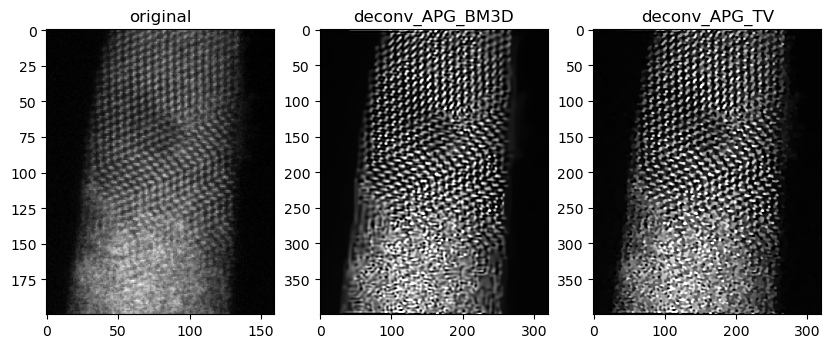

In [3]:
# demo on real experimental data

data = tf.imread('Au_108868.tiff')
data = data/np.max(data)

prb = np.loadtxt('prb_amp_108868.txt')

prb_sz = np.shape(prb)
 
psf = prb[prb_sz[0]//2-21//2:prb_sz[0]//2-21//2+21,prb_sz[1]//2-21//2:prb_sz[1]//2-21//2+21]**2
psf = psf/np.sum(psf.ravel())

scale = [2,2]

im_deconv_APG_BM3D,loss_APG_BM3D,rdiff_APG_BM3D = deconv(data,psf,scale,0.018,conv_med = ['dilation','average'], deconv_med='APG_BM3D')
im_deconv_APG_TV,loss_APG_TV,rdiff_APG_TV = deconv(data,psf,scale,1200,conv_med = ['dilation','average'], deconv_med='APG_TV')
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(data,cmap='gray',vmin=0,vmax=1)
plt.title('original')

plt.subplot(132)
plt.imshow(im_deconv_APG_BM3D,cmap='gray',vmin=0,vmax=1)
plt.title('deconv_APG_BM3D')

plt.subplot(133)
plt.imshow(im_deconv_APG_TV,cmap='gray',vmin=0,vmax=1)
plt.title('deconv_APG_TV')